# Повышение эффективности регрессионных моделей за счет исключения аномальных данных

В машинном обучении есть такая расхожая фраза: trash in, trash out. Что означает: мусор на входе, мусор на выходе.

Следует следить за тем, чтобы в обучающих данных не было выбросов, тогда модель демонстрирует гораздо более достоверные прогнозы. В этой работе мы прогнали данные через наш алгоритм детекции выбросов, основанный на SVD, после чего сумели повысить прогнозирующую способность моделей.

Подробно об этом исследовании см. [полный текст статьи](paper.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import sklearn.model_selection as sklm

## Чтение данных

In [2]:
df = pd.read_csv('data/data.csv')
df

,Просмотры,Показы,Лайки
0,475.0,5176.0,16.0
1,174.0,2222.0,4.0
2,490.0,5584.0,3.0
3,665.0,6759.0,8.0
4,971.0,6736.0,12.0
...,...,...,...
495,287.0,3156.0,10.0
496,310.0,4359.0,6.0
497,275.0,4176.0,2.0
498,222.0,2976.0,4.0


## Трижды вложенный цикл

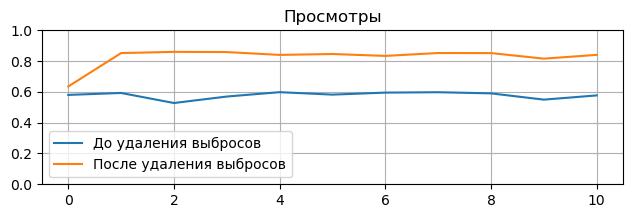

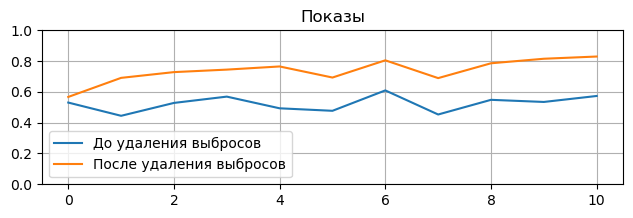

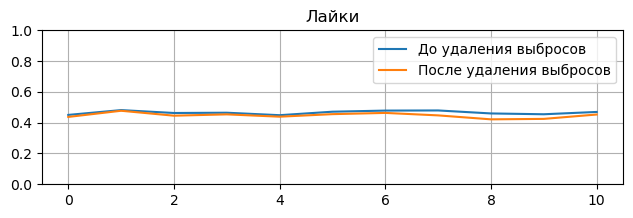

In [3]:
# Это список признаков. Каждый из них поочередно будет играть роль целевой функции
cols = df.columns

# Ряд от 0 до K -- это прцент данных, которые мы готовы признать выбросами и удалить их. 
# Изменяется в цикле. 0 -- вообще ничего не выкидиваем, 11 -- выкидываем 10%
K = 11

# Цикл по целевым функциям
for target in cols:
    
    # Списки, к которые будут записаны скоры регрессионных моделей: до и после удаления  выбросов
    #  В них будет по 11 элементов  для каждого target'а
    before = []
    after = []
    
    # Цикл по проценту, выделяемому на выбросы
    for i in range(K):

        # Списки для скоров до усреднения
        # В них будет по 25 элементов
        score_before_list = []
        score_after_list = []

        # 25 запусков со случайным разбиением на train и test (random_state отключен)
        for j in range(25):

            # Разбиение
            df_train, df_test = sklm.train_test_split(df, test_size=0.2)

            # Нормализация (целевая функция не нормализуется)
            X_train = (df_train.drop(columns=[target]) - df_train.drop(columns=[target]).mean())/df_train.drop(columns=[target]).std()

            # Данные для обучения модели
            X_train = X_train.to_numpy()
            y_train = df_train[target].to_numpy()

            # Нормализация testэа по характеристикам train'а
            X_test = (df_test.drop(columns=[target]) - df_train.drop(columns=[target]).mean())/df_train.drop(columns=[target]).std()

            #  Данные для теста
            X_test = X_test.to_numpy()
            y_test = df_test[target].to_numpy()

            # Построение и обучение модели
            model = skl.LinearRegression()
            model.fit(X_train, y_train)

            # Скор модели
            m = model.score(X_test, y_test) 

            # Кривой костыль. Честно говоря, не помню, почему потребовал, чтобы скор был больше нуля... (((
            if m > 0:

                score_before_list.append(model.score(X_test, y_test))

            # Сингулярное разложение train'а
            U, Sigma, V = np.linalg.svd(X_train, full_matrices=False)

            # Перевод обучающих данных в сингулярный базис и постороение проектции на первое главное направление
            S_train = np.dot(X_train, V.T)
            S_train_reduce = np.concatenate((S_train[:, :1], np.zeros((len(S_train), np.shape(S_train)[1]-1))), axis=1)
            X_train_reduce = np.dot(S_train_reduce, V)

            #  Вычисление отклонений на train'е
            residuals_train = np.linalg.norm(X_train - X_train_reduce, axis=1)
            threshold_train = np.percentile(residuals_train, 100 - i)

            # Номера выбросов на Train'е
            anomaly_indices_train = np.where(residuals_train > threshold_train)[0]

            # Дропаем аномалии
            df_train = df_train.drop(df_train.iloc[anomaly_indices_train].index)

            # Теперь в данных произошли изменения и их нормализация нарушилась. Снова нормализуем
            X_train = (df_train.drop(columns=[target]) - df_train.drop(columns=[target]).mean())/df_train.drop(columns=[target]).std()

            # Готовим данные для модели
            X_train = X_train.to_numpy()
            y_train = df_train[target].to_numpy()

            # Учим модель
            model = skl.LinearRegression()
            model.fit(X_train, y_train)

            # Дальше все то же самое для test'а
            X_test = (df_test.drop(columns=[target]) - df_train.drop(columns=[target]).mean())/df_train.drop(columns=[target]).std()
            X_test = X_test.to_numpy()

            S_test = np.dot(X_test, V.T)

            S_test_reduce = np.concatenate((S_test[:, :1], np.zeros((len(S_test), np.shape(S_test)[1]-1))), axis=1)
            X_test_reduce = np.dot(S_test_reduce, V)

            residuals_test = np.linalg.norm(X_test - X_test_reduce, axis=1)
            anomaly_indices_test = np.where(residuals_test > threshold_train)[0]

            df_test = df_test.drop(df_test.iloc[anomaly_indices_test].index)

            X_test = (df_test.drop(columns=[target]) - df_train.drop(columns=[target]).mean())/df_train.drop(columns=[target]).std()
            X_test = X_test.to_numpy()
            y_test = df_test[target].to_numpy()

            # Считаем скор на test'е
            m = model.score(X_test, y_test) 

            if m > 0:

                score_after_list.append(model.score(X_test, y_test))

        # Заносим усредненные по 25 запускам данные в списки скоров
        before.append(np.array(score_before_list).mean())
        after.append(np.array(score_after_list).mean())


    # Рисуем картинку
    plt.figure(figsize = (7.5, 2))
    plt.grid()
    
    plt.xlim([-0.5, K-0.5])
    plt.ylim([0, 1])
    
    plt.plot(before, '-', label = 'До удаления выбросов')
    plt.plot(after,  '-', label = 'После удаления выбросов')
    plt.title(target)
    plt.legend()
    #plt.savefig(target + '.png', dpi = 300, bbox_inches = 'tight')
    plt.show()